In [1]:
import pandas as pd
import glob
import math
import contractions
from nltk.corpus import stopwords
from nltk import word_tokenize
import keras
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.utils import plot_model, vis_utils
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint



/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
# Data has been preprocessed by removing all the " characters: sed -i 's/"//g' *.txt
# as this caused issues reading the data as a csv file. 
# Also had to remove a blank line from 2016 test data 

# Load the data
fileGlob = glob.glob('./task1Data/twitter*.txt')

traindf = pd.concat([pd.read_csv(f, sep='\t', header=None, keep_default_na=False) for f in fileGlob], ignore_index = True)
traindf.columns = ['id','label','raw' ,'date']
traindf = traindf.drop(['date'], axis=1)

In [3]:
def preprocess(tweet, stop_words):
    # Handle utf8 unicode problems
    tweet = tweet.encode('utf8').decode('unicode_escape', 'ignore') 
    tweet = contractions.fix(tweet)
    tweetLine = word_tokenize(tweet)
    # remove all tokens that are not alphabetic or stopwords, also lower the words
    tweetLine = [word.lower() for word in tweetLine if word.isalpha() and  word not in stop_words]
    return tweetLine

stop_words = stopwords.words('english')

traindf['text'] = traindf.apply(lambda row: preprocess(row['raw'], stop_words),axis=1)


/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\m'
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\o'
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\,'
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\l'
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\_'
  

/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\:'
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\.'
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\)'
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\e'
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\h'
  

In [4]:
# Sanity check to ensure tweets are tweet length
maxi = 0
for text in traindf.text:
    length = len(' '.join(text))
    if length > maxi:
        maxi = length
        sanityCheck = text
print(maxi)
print(sanityCheck)

maxi = 0
for text in traindf.text:
    length = len(text)
    if length > maxi:
        maxi = length
        sanityCheck = text
print(maxi)
print(sanityCheck)

143
['work', 'friday', 'night', 'lt', 'lt', 'lt', 'lt', 'lt', 'venice', 'beach', 'bound', 'morning', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt']
40
['work', 'friday', 'night', 'lt', 'lt', 'lt', 'lt', 'lt', 'venice', 'beach', 'bound', 'morning', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt']


In [5]:
pd.options.display.max_colwidth = 10000
sample = traindf.loc[traindf.id == 629791787448692736]
# Further sanity checks for preprocessing
print(sample.raw)
print(sample.text)
print(sample.label)


32118    Todd Bowles and players talk about what they're expecting from Saturday night's Green &amp; White practice at MetLife: http://t.co/JsjyJPfouL
Name: raw, dtype: object
32118    [todd, bowles, players, talk, expecting, saturday, night, green, amp, white, practice, metlife, http]
Name: text, dtype: object
32118    neutral
Name: label, dtype: object


In [6]:
# create index-word relationship
word2idx = {'<PAD>': 0, '<UNK>' : 1, }
idx2word ={}
sents_as_ids = []
for line in traindf.text:
    sentId = []
    for word in line:
        if word in word2idx:
            sentId.append(word2idx[word])
            continue
        count = len(word2idx)
        word2idx[word] = count
        idx2word[count] = word
        sentId.append(count)
    sents_as_ids.append(sentId)
    

In [7]:
def convertTextToNumSeq(text, word2idx,MAXIMUM_LENGTH):
    # Convert text to a sequence of numbers
    numSeq = []
    for word in text:
        if word in word2idx:
            numSeq.append(word2idx[word])
        else:
            # If unseen put in unknown
            numSeq.append(1) 
                
    numSeq = pad_sequences([numSeq],MAXIMUM_LENGTH )
    return numSeq

MAXIMUM_LENGTH = 50 # Motivated because max sequence of words i had was 40

traindf['numSeq'] = traindf.apply(lambda row: convertTextToNumSeq(row['text'], word2idx, MAXIMUM_LENGTH),axis=1)

In [8]:
# Split data into training and validtion sets
x_train, x_val, y_train, y_val = train_test_split(traindf.numSeq, traindf.label, stratify=traindf.label, random_state =2)
# Show the class imbalance
print(y_val.value_counts())
x_train = np.array([x for y in x_train for x in y]).reshape(len(x_train),MAXIMUM_LENGTH)
x_val = np.array([x for y in x_val for x in y]).reshape(len(x_val),MAXIMUM_LENGTH)

#Y data is categorical therefore must be converted to a vector
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
y_train = onehot_encoder.fit_transform(np.array(y_train).reshape(len(y_train),1))
y_val = onehot_encoder.transform(np.array(y_val).reshape(len(y_val),1))

neutral     5648
positive    4976
negative    1960
Name: label, dtype: int64


In [9]:
VOCAB_SIZE = 60000

EMBED_SIZE = 100
# Create a basic LSTM model 
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE,input_length=MAXIMUM_LENGTH))
model.add(LSTM(100))
model.add(Dense(3, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           6000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 6,080,703
Trainable params: 6,080,703
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Save the best weights to a file so we get the model with the best val acc
weightsFilePath="task1Weights.best.hdf5"
checkpoint = ModelCheckpoint(weightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit(x_train,y_train,epochs=5,batch_size=128,validation_data=(x_val, y_val), callbacks=[checkpoint],verbose=1)

Train on 37750 samples, validate on 12584 samples
Epoch 1/5
37750/37750 [==============================] - 33s 863us/step - loss: 0.8580 - acc: 0.5892 - val_loss: 0.7717 - val_acc: 0.6479

Epoch 00001: val_acc improved from -inf to 0.64789, saving model to task1Weights.best.hdf5
Epoch 2/5
37750/37750 [==============================] - 30s 806us/step - loss: 0.5884 - acc: 0.7535 - val_loss: 0.8076 - val_acc: 0.6400

Epoch 00002: val_acc did not improve from 0.64789
Epoch 3/5
37750/37750 [==============================] - 30s 804us/step - loss: 0.4031 - acc: 0.8424 - val_loss: 0.9171 - val_acc: 0.6140

Epoch 00003: val_acc did not improve from 0.64789
Epoch 4/5
37750/37750 [==============================] - 31s 810us/step - loss: 0.2768 - acc: 0.8961 - val_loss: 1.1299 - val_acc: 0.6179

Epoch 00004: val_acc did not improve from 0.64789
Epoch 5/5
37750/37750 [==============================] - 31s 811us/step - loss: 0.1932 - acc: 0.9288 - val_loss: 1.3594 - val_acc: 0.6084

Epoch 00005: v

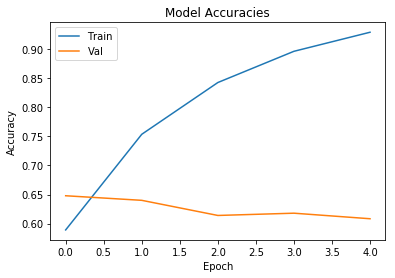

In [11]:
# Plot model performance
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
plt.show()

In [12]:
# Notes on different experiments for preprocessing and architecture:
# With stop word removal, stemming, vocab size 60000, padding at 50 and contractions, get 0.65 val accuracy 
# decresing vocab size causes errors, bad results and strange effects
# adding dropout 0.1 between embedding and lstm made it worse by 2%

In [13]:
# Load the weights from the model with the best val accuracy
model.load_weights(weightsFilePath)

# Get predictions and perfrom de-onehotencoding for the confusion matrix
y_pred = model.predict(x_val)
y_pred = np.array([[1 if i == max(sc) else 0 for i in sc] for sc in y_pred])
y_pred_text = onehot_encoder.inverse_transform(y_pred)
y_val_text = onehot_encoder.inverse_transform(y_val)

In [14]:
cm = confusion_matrix(y_val_text, y_pred_text)

In [15]:
def averageFScore(cm):
    (noClasses,_) = cm.shape
    fsum = 0
    recalls = []
    precisions = []
    for i in range(noClasses):
        correct = cm[i][i]
        # if row or col total is zero set to 1 to avoid nans
        rowTotal = max(sum(cm[i]),1)
        colTotal = max(sum(cm[:,i]),1)
        recall = correct / rowTotal
        recalls.append(recall)
        precision = correct / colTotal
        precisions.append(precision)
        
        # Get denominator, if 0 set to 1 to avoid nans
        denominator = precision + recall if precision + recall > 0 else 1
        f1 = 2*precision*recall / denominator
        fsum += f1
    return fsum/noClasses, recalls, precisions

In [16]:
# Rows are the actual, columns are the predicted.  negative, neutral, positve
print(cm)
valAccuracy = (cm[0][0] + cm[1][1] + cm[2][2])/sum(sum(cm))
avgfscore, recalls, precisions = averageFScore(cm)
print(f"Average fscore: {avgfscore}")
print(f"valAccuracy {valAccuracy}")
print(f"Recalls for each class: {recalls}")
print(f"Precisions for each class {precisions}")

[[ 730 1006  224]
 [ 374 4534  740]
 [ 159 1928 2889]]
Average fscore: 0.5995992251834573
valAccuracy 0.6478862047043865
Recalls for each class: [0.37244897959183676, 0.8027620396600567, 0.5805868167202572]
Precisions for each class [0.5779889152810768, 0.6071237279057311, 0.7498053464832598]


## Performance on Test Data

In [17]:
# Load the data
testdf = pd.read_csv('./SemEval2017-task4-test/SemEval2017-task4-test.subtask-A.english.txt', sep='\t', header=None, keep_default_na=False)
testdf.columns = ['id','label','raw']

# Preprocess and convert to numbers
testdf['text'] = testdf.apply(lambda row: preprocess(row['raw'], stop_words),axis=1)
testdf['numSeq'] = testdf.apply(lambda row: convertTextToNumSeq(row['text'], word2idx, MAXIMUM_LENGTH),axis=1)



/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\ '
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\o'
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\_'
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\S'
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
x_test = testdf['numSeq']
y_test = testdf['label']

# Prelim analysis to indicate class imbalance
print(y_test.value_counts())


# Onehot encode the y data
y_test = onehot_encoder.transform(np.array(y_test).reshape(len(y_test),1))
x_test = np.array([x for y in x_test for x in y]).reshape(len(x_test),MAXIMUM_LENGTH)

neutral     5937
negative    3972
positive    2375
Name: label, dtype: int64


In [19]:
# Get predictions and prepare data for confusion matrix
y_testpred = model.predict(x_test)
y_testpred = np.array([[1 if i == max(sc) else 0 for i in sc] for sc in y_testpred])
y_testpred_text = onehot_encoder.inverse_transform(y_testpred)
y_test_text = onehot_encoder.inverse_transform(y_test)

In [20]:
# Create confusion matrix and get some key information from it. 
cm = confusion_matrix(y_test_text, y_testpred_text, labels=['negative','neutral','positive'])

print(cm)
testAccuracy = (cm[0][0] + cm[1][1] + cm[2][2])/sum(sum(cm))
avgfscore, recalls, precisions = averageFScore(cm)
print(f"Average fscore: {avgfscore}")
print(f"testAccuracy {testAccuracy}")
print(f"Recalls for each class: {recalls}")
print(f"Precisions for each class {precisions}")


[[1629 2139  204]
 [ 764 4662  511]
 [  79 1182 1114]]
Average fscore: 0.5684618780473634
testAccuracy 0.6028166720937805
Recalls for each class: [0.41012084592145015, 0.7852450732693279, 0.4690526315789474]
Precisions for each class [0.6589805825242718, 0.5839909808342728, 0.6090759978130126]


Confusion matrix shows prediction in columns of negative, neutral and positive. Groundtruth are in rows of negative, neutral and positive. 
Test accuracy is 60.3%. We can see from the confusion matrix that the classifier particularly struggles to classify when the text is negative, its recall of negative samples is 41.0%. Therefore to help improve this model we could try concentrating on features that help to classify negative text. 